In [21]:
import os
import sys
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import torch
import anndata as ad
from sklearn import metrics, cluster
import re
import chemprop

import biolord

import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
from biolord_utils import compute_prediction, compute_baseline, create_df
from biolord_params import (
    groups,
    groups_colors,
    module_params,
    trainer_params,
    ood_drugs,
)

In [23]:
adata = ad.read_h5ad("C:\\Users\\admin\\Documents\\scFiLM\\data\\sciplex3_biolord.h5ad")

In [13]:
adata_scfilm = ad.read_h5ad("C:\\Users\\admin\\Documents\\scFiLM\\data\\sciplex_seurat.h5ad")

In [30]:
adata_scfilm.obs.drug_celltype_dose.unique()

['A549_Enzastaurin (LY317615)_1000.0', 'A549_Raltitrexed_10.0', 'A549_Vehicle_0.0', 'A549_Lenalidomide (CC-5013)_10.0', 'A549_Divalproex Sodium_1000.0', ..., 'K562_TG101209_10000.0', 'K562_Raltitrexed_10000.0', 'K562_Panobinostat (LBH589)_10000.0', 'K562_AT9283_10000.0', 'K562_Mocetinostat (MGCD0103)_10000.0']
Length: 2218
Categories (2218, object): ['A549_2-Methoxyestradiol (2-MeOE2)_10.0', 'A549_2-Methoxyestradiol (2-MeOE2)_100.0', 'A549_2-Methoxyestradiol (2-MeOE2)_1000.0', 'A549_2-Methoxyestradiol (2-MeOE2)_10000.0', ..., 'MCF7_Zileuton_10.0', 'MCF7_Zileuton_100.0', 'MCF7_Zileuton_1000.0', 'MCF7_Zileuton_10000.0']

In [18]:
type(adata_scfilm.obs.fmfp.iloc[0])

str

In [12]:
adata.obs.split_ood.unique()

['train', 'test', 'ood']
Categories (3, object): ['ood', 'test', 'train']

In [20]:
adata.obs

,cell_type,dose,dose_character,dose_pattern,g1s_score,g2m_score,pathway,pathway_level_1,pathway_level_2,product_dose,...,SMILES,split_ood_finetuning,split_ho_epigenetic,split_ho_epigenetic_all,split_random,split_ood,pathway_level_1_groups,pathway_groups,_indices,_scvi_cell_type
index,,,,,,,,,,,,,,,,,,,,,
A01_E09_RT_BC_100_Lig_BC_245-0-0-0,A549,1000.0,1000,2,1.155964,2.475312,TGF-beta/Smad,PKC signaling,PKC activitiy,Enzastaurin (LY317615)_1000,...,Cn1cc(C2=C(c3cn(C4CCN(Cc5ccccn5)CC4)c4ccccc34)C(=O)NC2=O)c2ccccc21,train,train,train,train,train,NA,NA,0,0
A01_E09_RT_BC_101_Lig_BC_109-0-0-0,A549,0.0,0,3,0.000000,0.000000,Vehicle,Vehicle,Vehicle,Vehicle_0,...,CS(C)=O,train,train,train,train,train,NA,NA,1,0
A01_E09_RT_BC_101_Lig_BC_280-0-0-0,A549,1000.0,1000,2,1.637016,0.867074,Ubiquitin,Epigenetic regulation,Histone deacetylation,Divalproex Sodium_1000,...,CCCC(CCC)C(=O)O.CCCC(CCC)C(=O)[O-].[Na+],train,train,train,train,train,Epigenetic regulation,Histone deacetylation,2,0
A01_E09_RT_BC_101_Lig_BC_86-0-0-0,A549,100.0,100,3,0.600151,0.000000,Cell Cycle,Cell cycle regulation,Aurora kinase activity,MLN8054_100,...,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)cccc2F)=NC3)cc1,train,train,train,ood,train,Cell cycle regulation,Cell cycle regulation,3,0
A01_E09_RT_BC_102_Lig_BC_215-0-0-0,A549,1000.0,1000,2,0.882834,0.882834,DNA Damage,Epigenetic regulation,Histone deacetylation,Sodium Phenylbutyrate_1000,...,O=C(CCCc1ccccc1)O[Na],train,test,test,train,train,Epigenetic regulation,Histone deacetylation,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H12_F10_RT_BC_8_Lig_BC_55-1-4,K562,100.0,100,3,1.078251,3.581061,DNA Damage,DNA damage & DNA repair,Alkylating agent,Busulfan _100,...,CS(=O)(=O)OCCCCOS(C)(=O)=O,train,train,train,ood,train,DNA damage & DNA repair,DNA damage & DNA repair,354635,1
H12_F10_RT_BC_93_Lig_BC_202-1-4,K562,0.0,0,1,1.326905,2.009802,NA,Vehicle,Vehicle,Vehicle_0,...,CS(C)=O,test,test,test,train,test,NA,NA,354636,1
H12_F10_RT_BC_97_Lig_BC_224-1-4,K562,100.0,100,3,0.000000,2.451281,Metabolism,Metabolic regulation,Isocitrate dehydrogenase activity,Ivosidenib (AG-120)_100,...,N#Cc1ccnc(N2C(=O)CCC2C(=O)N(c2cncc(F)c2)C(C(=O)NC2CC(F)(F)C2)c2ccccc2Cl)c1,train,train,train,test,train,NA,NA,354637,1


In [24]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=["rdkit2d_dose"],
    categorical_attributes_keys=["cell_type"],
    retrieval_attribute_key=None,
)

INFO     Generating sequential column names                                                                        


In [25]:
model = biolord.Biolord(
    adata=adata,
    n_latent=256,
    model_name="sciplex3",
    module_params=module_params,
    train_classifiers=False,
    split_key="split_ood",
)

Seed set to 42


In [26]:
model.train(
    max_epochs=10,
    batch_size=512,
    plan_kwargs=trainer_params,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=0,
    enable_checkpointing=False
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\admin\.conda\envs\biolord\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\admin\.conda\envs\biolord\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers wh

Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [28]:
model.training_plan.epoch_history['biolord_metric']

[np.float64(-36.14256683814114),
 np.float64(0.0),
 np.float64(-7.945800958779351),
 np.float64(0.0),
 np.float64(-4.124917484562973),
 np.float64(0.0),
 np.float64(-2.1454601665509156),
 np.float64(0.0),
 np.float64(-0.510775339757574),
 np.float64(0.0),
 np.float64(0.06613431434179175),
 np.float64(0.0),
 np.float64(0.08433461420494935),
 np.float64(0.0),
 np.float64(0.49937365640854015),
 np.float64(0.0),
 np.float64(0.6868480852451818),
 np.float64(0.0),
 np.float64(0.6057195624914663),
 np.float64(0.0)]

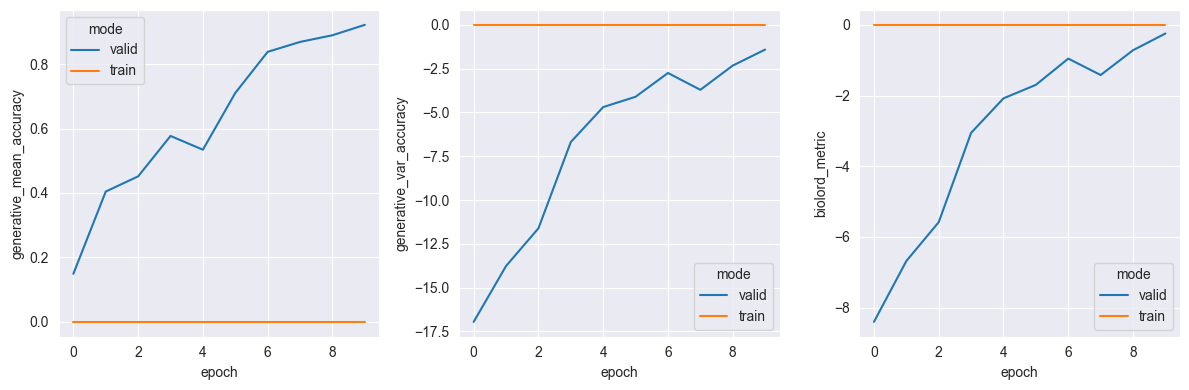

In [11]:
vals = ["generative_mean_accuracy", "generative_var_accuracy", "biolord_metric"]
fig, axs = plt.subplots(nrows=1, ncols=len(vals), figsize=(4 * len(vals), 4))

model.epoch_history = pd.DataFrame().from_dict(model.training_plan.epoch_history)
for i, val in enumerate(vals):
    sns.lineplot(
        x="epoch",
        y=val,
        hue="mode",
        data=model.epoch_history,
        ax=axs[i],
    )

plt.tight_layout()
plt.show()

In [12]:
idx_test_control = np.where(
    (adata.obs["split_ood"] == "test") & (adata.obs["control"] == 1)
)[0]

adata_test_control = adata[idx_test_control].copy()

idx_ood = np.where((adata.obs["split_ood"] == "ood"))[0]

adata_ood = adata[idx_ood].copy()
dataset_control = model.get_dataset(adata_test_control)
dataset_ood = model.get_dataset(adata_ood)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [20]:
adata_test_control.obs.product_name.unique()

['control']
Categories (1, object): ['control']

In [ ]:
res_all = {}

res_all["baseline"], _ = compute_baseline(
    model=model,
    adata=adata_ood,
    dataset=dataset_ood,
    dataset_control=dataset_control,
    use_DEGs=False,
    verbose=False,
)

res_all["biolord"], _ = compute_prediction(
    model=model,
    adata=adata_ood,
    dataset=dataset_ood,
    dataset_control=dataset_control,
    use_DEGs=False,
    verbose=False,
)

['A549', 'K562', 'MCF7']


108it [00:00, 190.12it/s]

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

In [14]:
res_all

{'baseline': {'A549_Alvespimycin_0.001': 0.9577896595001221,
  'A549_Alvespimycin_0.01': 0.872689962387085,
  'A549_Alvespimycin_0.1': 0.8574289083480835,
  'A549_Alvespimycin_1.0': 0.8649262189865112,
  'A549_Belinostat_0.001': 0.9531940221786499,
  'A549_Belinostat_0.01': 0.9444059729576111,
  'A549_Belinostat_0.1': 0.8595383763313293,
  'A549_Belinostat_1.0': -0.01871204376220703,
  'A549_Dacinostat_0.001': 0.8300580382347107,
  'A549_Dacinostat_0.01': 0.6379208564758301,
  'A549_Dacinostat_0.1': 0.0739450454711914,
  'A549_Dacinostat_1.0': -0.15586745738983154,
  'A549_Flavopiridol_0.001': 0.9525638222694397,
  'A549_Flavopiridol_0.01': 0.8018192052841187,
  'A549_Flavopiridol_0.1': 0.9490960240364075,
  'A549_Flavopiridol_1.0': 0.9569388031959534,
  'A549_Givinostat_0.001': 0.9485700130462646,
  'A549_Givinostat_0.01': 0.9401002526283264,
  'A549_Givinostat_0.1': 0.839423418045044,
  'A549_Givinostat_1.0': 0.01613783836364746,
  'A549_Hesperadin_0.001': 0.9367258548736572,
  'A549